In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

import emcee
import corner
from scipy.optimize import minimize
from scipy.stats import gamma,beta

#for multiprocessing
import os
from multiprocessing import cpu_count
from multiprocessing import Pool
import time

import func as model2
np.random.seed(42)

### Tool function for the fit

In [3]:
def multiprocess_fit(starting_points,n_walkers, n_params,n_steps,burn_steps, log_probability, args,moves=emcee.moves.StretchMove(),multiprocess=True):
    if multiprocess==True:
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(n_walkers, n_params, log_probability, args=args,moves=moves,pool=pool)#args are the params that won't change during the mcmc run
            print("Start counting")
            start = time.time()
            sampler.reset()
            print("Running multiprocessing sampler,burn-in,phase","\n")
            state=sampler.run_mcmc(starting_points, burn_steps, progress=True);
            sampler.reset()
            print("Running multiprocessing sampler","\n")
            sampler.run_mcmc(state, n_steps, progress=True)
            end = time.time()
            multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    else:
        sampler = emcee.EnsembleSampler(n_walkers, n_params, log_probability, args=args,moves=moves)#args are the params that won't change during the mcmc run
        print("Start counting")
        start = time.time()
        sampler.reset()
        print("Running monoprocess sampler,burn-in,phase","\n")
        state=sampler.run_mcmc(starting_points, burn_steps, progress=True);
        sampler.reset()
        print("Running monoprocess sampler","\n")
        sampler.run_mcmc(state, n_steps, progress=True)
        end = time.time()
        multi_time = end - start
        print("Monoprocessing took {0:.1f} seconds".format(multi_time))        
    return sampler

## Pre-processing
Load data,Find True Model parameters (MLE)

In [379]:
fileName = 'UMIK_allSources.csv'
path_to_directory = 'data2/'
df = pd.read_csv(f'{path_to_directory + fileName}', index_col=False,usecols=["generationtime","growth_rate","division_ratio","lineage_ID","generation","length_birth","source"])
df = df.dropna()

#restrict to SINGLE sugar
sugar="Ace"

print(df["source"].unique())
df=df[df["source"]==sugar]
#df.info()
df.head()

['Ace' 'DMa' 'Glu' 'Gly' 'Lac' 'Pyr' 'Rha' 'Suc' 'Xyl']


,division_ratio,generationtime,length_birth,growth_rate,lineage_ID,generation,source
0,0.502662,3.333333,1.690785,0.193974,0.0,0.0,Ace
1,0.530211,2.333333,1.843365,0.197585,0.0,1.0,Ace
2,0.524340,3.500000,1.587268,0.181141,0.0,2.0,Ace
3,0.470555,7.333333,1.485887,0.094078,0.0,3.0,Ace
4,0.464436,8.833333,1.531784,0.080047,0.0,4.0,Ace


In [381]:
df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])

def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)



clean_ace = df.dropna()


q1, q3 = clean_ace['protein_level'].quantile([0.25, 0.75])
iqr           = q3 - q1
lower_fence   = q1 - 1.5 * iqr
upper_fence   = q3 + 1.5 * iqr

# 4. Keep only non-outliers
df = clean_ace[(clean_ace['protein_level'] >= lower_fence) & (clean_ace['protein_level'] <= upper_fence)]



### Initialize array of initial cells lengths (manipulations of the pandas dataframe)

In [384]:
#INITIALIZE ARRAY OF INITIAL LENGTHS
unique_lineages = df["lineage_ID"].unique()#order from 0 to 99 lineages
initial_mass = np.empty(len(unique_lineages))#create a void array with length 
temp_mask=np.ones(len(unique_lineages))
print(unique_lineages.shape,initial_mass.shape)

(99,) (99,)


In [385]:
len(df["length_birth"].dropna())

572

In [386]:
for j,i in enumerate(unique_lineages):
    lineage_mask= (df['lineage_ID'] == i)
    temp=df.loc[lineage_mask]
    
    temp=temp.loc[temp["generation"]==0]#if first mass is not there this will be empty
    if temp.empty:
        df=df[df["lineage_ID"]!=i]#drops all the rows of that lineage 
        print("No initial mass for lineage",i)        
    else: 
        initial_mass[j]=temp["length_birth"]

#print(initial_mass)
#print(unique_lineages.shape)
#a volte manca la massa iniziale di qualche lignaggio

#remove lineages that have any generation time==0
null_lineages=df[df["generationtime"]==0]["lineage_ID"]
print(null_lineages)
for null_lineage in null_lineages:
    df=df[df["lineage_ID"]!=null_lineage]

No initial mass for lineage 7.0
No initial mass for lineage 8.0
No initial mass for lineage 71.0
No initial mass for lineage 81.0
No initial mass for lineage 86.0
No initial mass for lineage 92.0
No initial mass for lineage 108.0
Series([], Name: lineage_ID, dtype: float64)


C:\Users\yusuf\AppData\Local\Temp\ipykernel_9604\3531497033.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_mass[j]=temp["length_birth"]


In [387]:
initial_mass = df["length_birth"].dropna()

In [388]:
print(df.shape,initial_mass.shape)

(540, 8) (540,)


In [389]:
timest=df["generationtime"].to_numpy()#small difference in the column name: in synthetic data is "time_division"
alphast=df["growth_rate"].to_numpy()#in synthetic data is "alpha"
fst=df["division_ratio"].to_numpy()#in synthetic data is "f"
lineagest=df["lineage_ID"].to_numpy(dtype=np.integer)#need an integer to use as index
generationst=df["generation"].to_numpy()#in synthetic data is generation_N
massest=df["length_birth"].to_numpy()#for check purposes, in synthetic data is mass_birth
print(timest.shape,alphast.shape,fst.shape,lineagest.shape,generationst.shape,massest.shape)


print(timest.mean(),timest.std(),timest.min(),timest.max())

(540,) (540,) (540,) (540,) (540,) (540,)
3.965123456869425 1.6097911851414757 1.16666666669 12.33333333358


## Infere starting point for MLE from datas

In [391]:
u=min(massest)
v=max(massest)
omega2=1/min(timest)
mean_alpha=np.mean(alphast)
var_alpha=np.std(alphast)**2
var_f=np.std(fst)**2
mean_f=np.mean(fst)

#init distr for alpha and f parameters
alpha2 = -( ( mean_f * (var_f + (mean_f**2)-mean_f) ) / var_f )
beta2 = ( (var_f + (mean_f**2)-mean_f) * (mean_f-1) )/var_f

#retrieve alpha parameters starting from given mean and variance:
rate1=mean_alpha/var_alpha
alpha1=mean_alpha*rate1
scale1=1/rate1
print("Inferred values for \n u,v,omega2,alpha2,beta2,alpha1,scale1: \n", u,v,omega2,alpha2,beta2,alpha1,scale1)

Inferred values for 
 u,v,omega2,alpha2,beta2,alpha1,scale1: 
 1.17639456310513 3.24286617062258 0.8571428571257143 113.03341200274768 114.88860830983732 12.577505581960258 0.013439851377596516


### MLE 6 parameters, vfixed (initial values for emcee)

In [393]:
"""np.set_printoptions(suppress=True)#suppress scientific notation

#6 variables fit (v fixed)

def log_likelihood_vfixed(vars,v,initial_mass,lineages,t,alpha,f_i):#params will be ALL the parameters that are changeable
    params=[vars[0],v,vars[1],vars[2],vars[3],vars[4],vars[5]]#u, v, omega2,a1,b,a2,1/l
    return model2.log_likelihood(params,initial_mass,lineages,t,alpha,f_i)#this params is 7 elements long

nll = lambda *args: - log_likelihood_vfixed(*args) #definition of lambda negative log likelyhood
initial=np.array([u,omega2,alpha2,beta2,alpha1,scale1])
initial = initial + 1e-4*np.random.randn(6)
print("[u omega2 alpha2, beta2, alpha1, scale1 ] \n",initial)
soln = minimize(nll , initial, args=(v,initial_mass,lineagest,timest, alphast,fst),method='Nelder-Mead',bounds=((0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf)))
u, omega2,alpha2, beta2, alpha1, scale1  = soln.x #to save the best values for parameters m,u,v,omega1,omega2,alpha,c

print("solution values \n",soln.x)"""

'np.set_printoptions(suppress=True)#suppress scientific notation\n\n#6 variables fit (v fixed)\n\ndef log_likelihood_vfixed(vars,v,initial_mass,lineages,t,alpha,f_i):#params will be ALL the parameters that are changeable\n    params=[vars[0],v,vars[1],vars[2],vars[3],vars[4],vars[5]]#u, v, omega2,a1,b,a2,1/l\n    return model2.log_likelihood(params,initial_mass,lineages,t,alpha,f_i)#this params is 7 elements long\n\nnll = lambda *args: - log_likelihood_vfixed(*args) #definition of lambda negative log likelyhood\ninitial=np.array([u,omega2,alpha2,beta2,alpha1,scale1])\ninitial = initial + 1e-4*np.random.randn(6)\nprint("[u omega2 alpha2, beta2, alpha1, scale1 ] \n",initial)\nsoln = minimize(nll , initial, args=(v,initial_mass,lineagest,timest, alphast,fst),method=\'Nelder-Mead\',bounds=((0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf),(0.0001,np.inf)))\nu, omega2,alpha2, beta2, alpha1, scale1  = soln.x #to save the best values for parameters m,u,v,omega1,o

## Emcee with 7 variable parameters 

I try with different moves, as the default one seems inefficient

In [395]:
n_walkers=20
n_params=7
n_steps=30000
burn_steps=int(n_steps/10)
#moves=emcee.moves.DEMove()
moves=[(emcee.moves.DESnookerMove(), 0.1),(emcee.moves.DEMove(), 0.9 * 0.9),(emcee.moves.DEMove(gamma0=1.0), 0.9 * 0.1),]
#use each time a random move between these 3

In [405]:
os.environ["OMP_NUM_THREADS"] = "1"
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

12 CPUs


We must start with a very small u (which is also found by MLE if starting guess is small and not the one inferred from data), that way fit converges

In [408]:
starting_points=np.array([u, v, omega2,alpha2,beta2,alpha1,scale1])
#v_true, omega2_true,a1_true,b_true,a2_true,l_true
starting_points =starting_points + 1e-4 * np.random.randn(n_walkers, n_params)
np.set_printoptions(suppress=True)
print("starting vals: \n u v omega2 alpha2 beta2 alpha1 scale1 \n",starting_points[0])

args=(initial_mass,lineagest,timest,alphast,fst)

sampler=multiprocess_fit(starting_points,n_walkers, n_params,n_steps,burn_steps, model2.log_probability, args=args,moves=moves,multiprocess=True)


starting vals: 
 u v omega2 alpha2 beta2 alpha1 scale1 
 [  1.1764347    3.24308442   0.8571059  113.03343246 114.88850515
  12.57745265   0.01350172]
Start counting
Running multiprocessing sampler,burn-in,phase 



100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:03<00:00, 47.11it/s]


Running multiprocessing sampler 



100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [10:43<00:00, 46.62it/s]


Multiprocessing took 717.6 seconds


## Extract flat and non flat chains for anlysis

In [410]:
discard=200
thin=25

flat_samples=sampler.get_chain(discard=discard,thin=thin,flat=True)
samples=sampler.get_chain(discard=discard,thin=thin)
print(flat_samples.shape,samples.shape)

(23840, 7) (1192, 20, 7)


In [411]:
import numpy as np

param_names = ["u", "v", "omega2", "alpha2", "beta2", "alpha1", "scale1"]
param_medians = np.median(flat_samples, axis=0)

for name, median in zip(param_names, param_medians):
    print(f"{name}: median = {median:.5f}")


u: median = 1.60376
v: median = 8.18024
omega2: median = 1.69968
alpha2: median = 113.11235
beta2: median = 114.91877
alpha1: median = 12.05201
scale1: median = 0.01403


In [412]:
"""log_posteriors = np.array([
    model2.log_probability(p, *args) for p in flat_samples
])

best_idx = np.argmax(log_posteriors)
param_mode = flat_samples[best_idx]

for name, val in zip(param_names, param_mode):
    print(f"{name}: mode = {val:.5f}")"""


'log_posteriors = np.array([\n    model2.log_probability(p, *args) for p in flat_samples\n])\n\nbest_idx = np.argmax(log_posteriors)\nparam_mode = flat_samples[best_idx]\n\nfor name, val in zip(param_names, param_mode):\n    print(f"{name}: mode = {val:.5f}")'

### save chains in a txt file to re-use it:

In [414]:
#save the whole chain:
s_samples=sampler.get_chain(discard=0,thin=1)


filename = f"chain_{sugar}.txt"
original_shape = s_samples.shape


comment = f'Hyperparameters of {sugar} sugar are [n_steps n_walkers n_params ] = [{s_samples.shape[0]} {s_samples.shape[1]} {s_samples.shape[2]} ]'

print("original shape:",original_shape,"\n")

# Reshape the chain into a 1D array, reshaping a multi-dimensional array (samples) into a flat (one-dimensional)
flat_chain = s_samples.reshape(-1, s_samples.shape[-1])  # -1 infers total number of samples
#-1: This tells NumPy to infer the number of rows in the reshaped array based on the total number of elements in the original array and the number of columns.
#samples.shape[-1] sets the number of columns in the reshaped array.   

reshaped_shape = flat_chain.shape
print("flat shape:",reshaped_shape,"\n")

# Save the flattened chain to a text file:
np.savetxt(f"chain_{sugar}.txt", flat_chain,header=comment)

original shape: (30000, 20, 7) 

flat shape: (600000, 7) 



### old corner plot with alpha2,beta2,alpha1,scale1 instead of mean and variance:

Starting points for: 
 [u v omega2 alpha2 beta2 alpha1 scalae1] : 
 [1.17639456310513, 3.24286617062258, 0.8571428571257143, 113.03341200274768, 114.88860830983732, 12.577505581960258, 0.013439851377596516]


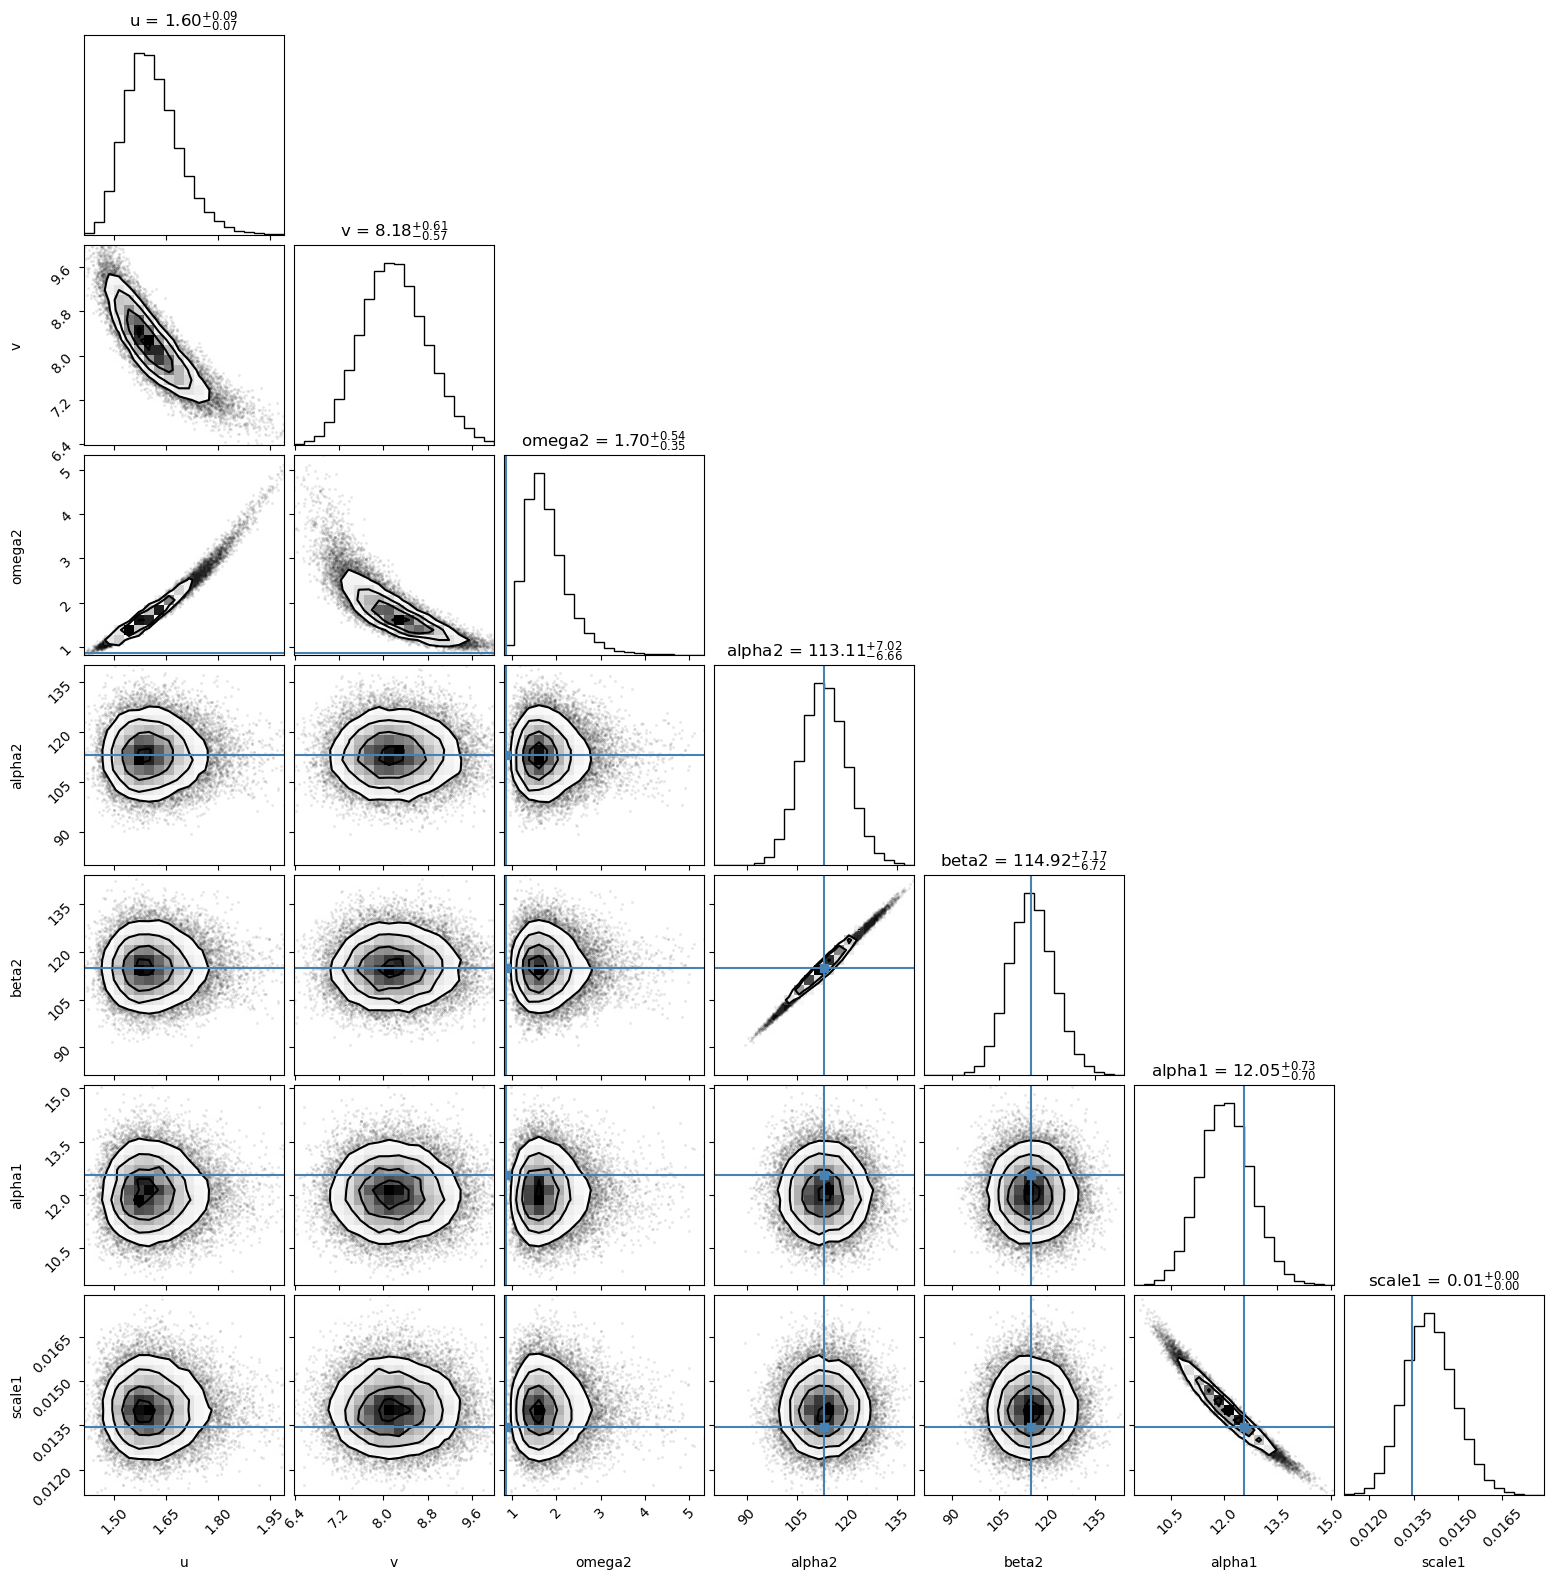

In [416]:
labels=["u","v","omega2","alpha2","beta2","alpha1","scale1"]
starting_points=[u,v,omega2,alpha2,beta2,alpha1,scale1]
print("Starting points for: \n [u v omega2 alpha2 beta2 alpha1 scalae1] : \n",starting_points)
#print("After burn-in: \n [u v omega2 alpha2 beta2 alpha1 scalae1] : \n",samplesdf[0,:])

fig = corner.corner(flat_samples,labels=labels,truths=starting_points,show_titles=True)
#to save interest plots in pdf:
#plt.savefig(f"emcee_model2_real_7params_{sugar}.pdf",format="pdf",bbox_inches="tight")

### new corner plots(with mean and std values)

#### Converting alpha2,beta2,alpha1,scale1 into mean_alpha,std_alpha,mean_f,std_f

In [419]:
#["u","v","omega2","alpha2","beta2","alpha1","scale1"]
#[0,   1,  2,       3,       4,      5,        6]


#I applied the chain transform on the flat samples as they're needed for the corner plot
samplesdf=pd.DataFrame(flat_samples)

#find initial values for alpha and f
mean_f=alpha2/(alpha2+beta2)
std_f=np.sqrt(alpha2*beta2/((alpha2+beta2)*(alpha2+beta2+1)**2))
mean_alpha=alpha1*scale1
std_alpha=np.sqrt(alpha1*scale1**2)


#f follows a beta distribution
samplesdf["mean_f"]=samplesdf[3]/(samplesdf[3]+samplesdf[4])
samplesdf["std_f"]=(samplesdf[3]*samplesdf[4])/((samplesdf[3]+samplesdf[4]+1)*(samplesdf[3]+samplesdf[4])**2)
samplesdf["std_f"]=np.sqrt(samplesdf["std_f"])
#alpha follows a gamma distribution
samplesdf["mean_alpha"]=samplesdf[5]*samplesdf[6] #mean_alpha=alpha*scale
samplesdf["std_alpha"]=samplesdf[5]*(samplesdf[6])**2#mean_alpha=alpha*(scale)**2
samplesdf["std_alpha"]=np.sqrt(samplesdf["std_alpha"])

samplesdf.drop(columns=[3,4,5,6],inplace=True)

samplesdf=samplesdf.to_numpy()



#### corner plot

Starting points for: 
 [u v omega2 mean_f std_f mean_alpha std_alpha] : 
 [1.17639456310513, 3.24286617062258, 0.8571428571257143, 0.4959301951067621, 0.032973207076884885, 0.16903980572243643, 0.04766413605434735]
After burn-in: 
 [u v omega2 mean_f std_f mean_alpha std_alpha] : 
 [1.60153385 7.66911563 1.73031472 0.49813483 0.03415942 0.17031085
 0.04880999]
arrival points: 
 [1.60375625 8.18024084 1.69968177 0.49592838 0.03303559 0.1690965
 0.04870695]


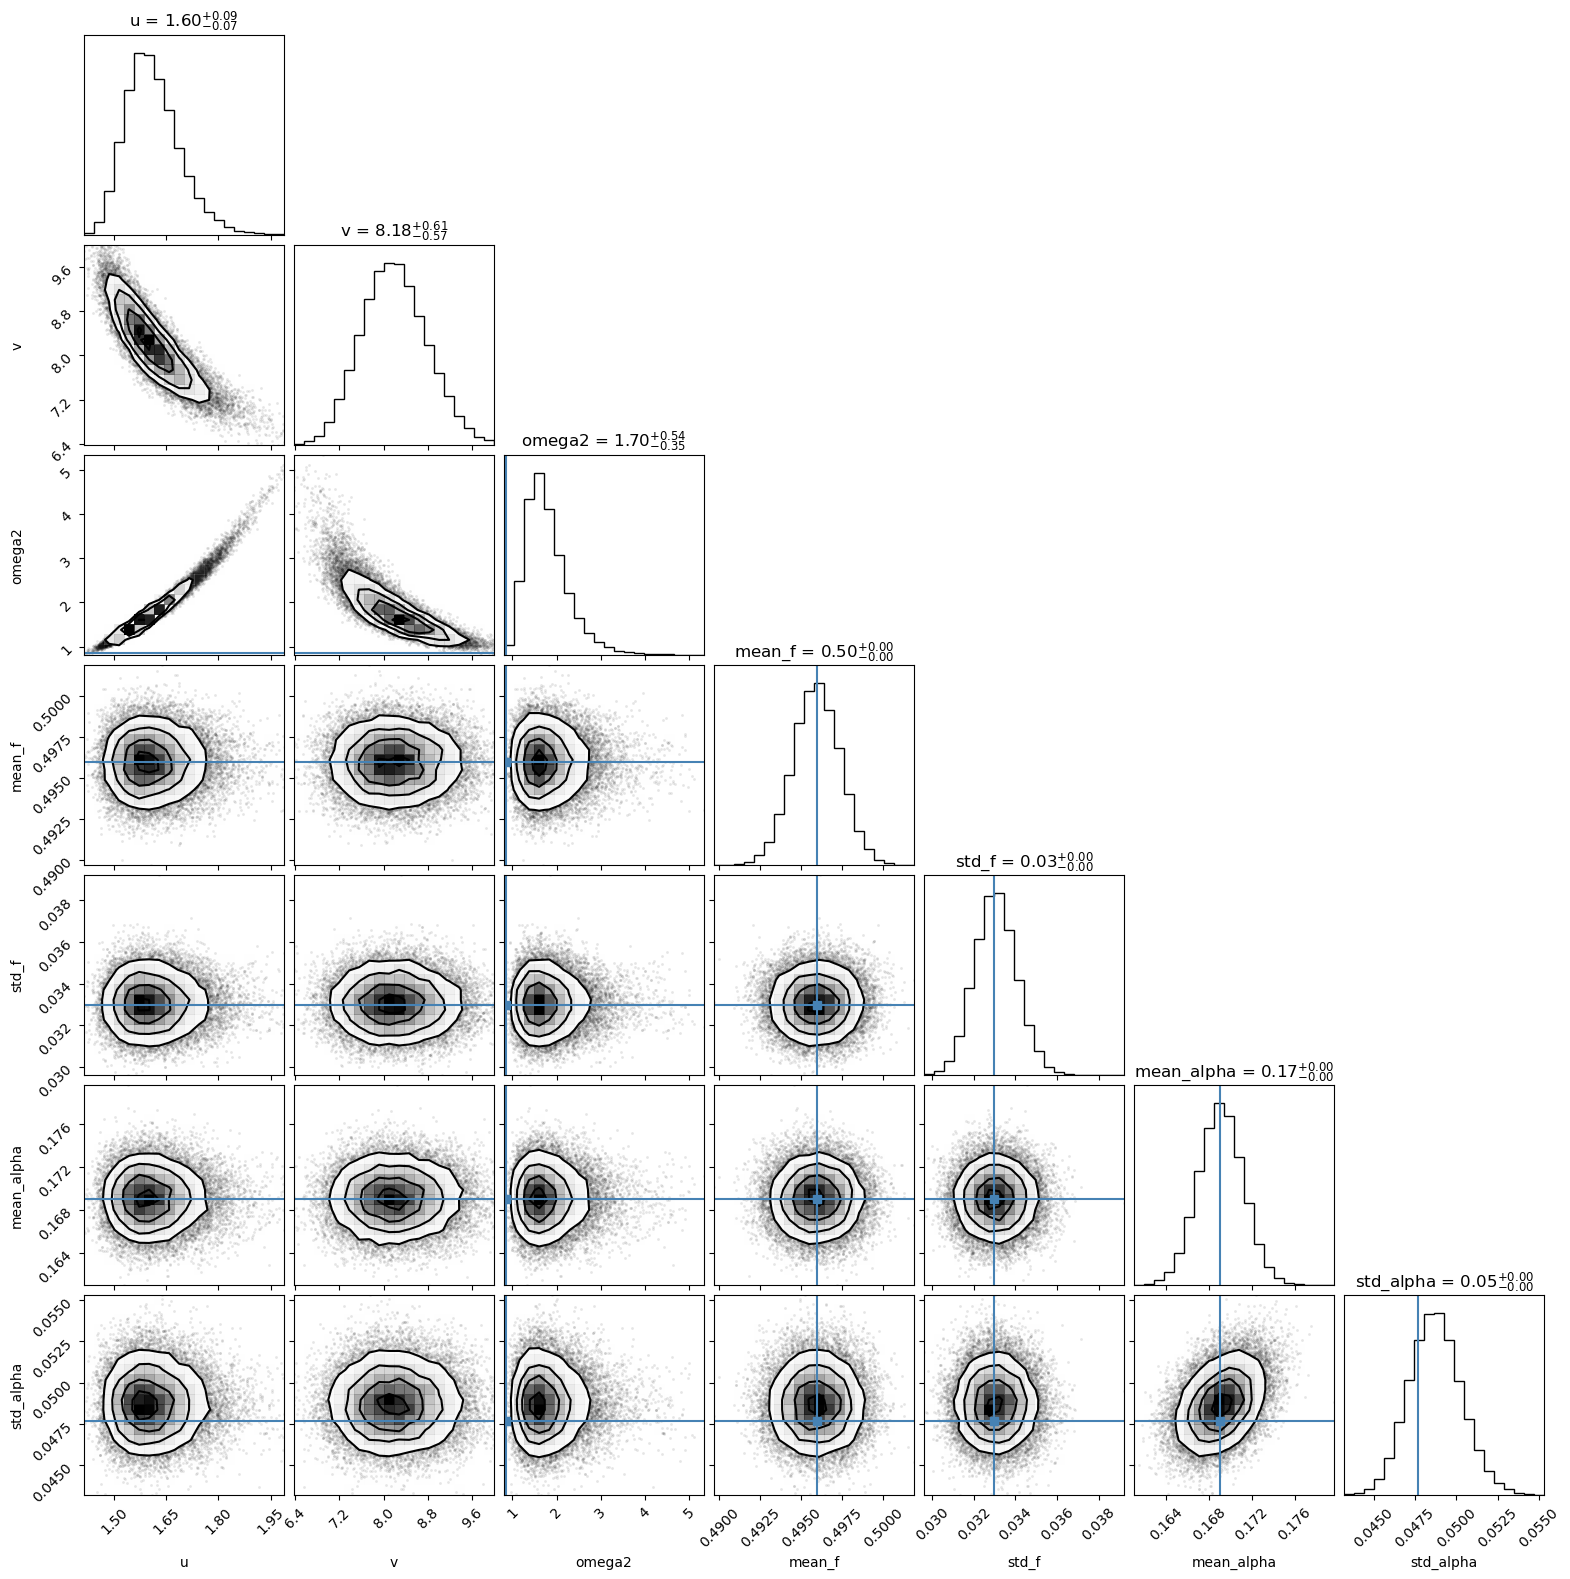

In [421]:
labels=["u","v","omega2","mean_f","std_f","mean_alpha","std_alpha"]
starting_points=[u,v,omega2,mean_f,std_f,mean_alpha,std_alpha]
print("Starting points for: \n [u v omega2 mean_f std_f mean_alpha std_alpha] : \n",starting_points)
print("After burn-in: \n [u v omega2 mean_f std_f mean_alpha std_alpha] : \n",samplesdf[0,:])


param_results=np.percentile(samplesdf, q=50, axis=0)#apply transformation of upper cell to obtain mean_f,stdf,mean-alpha,std_alpha
print("arrival points: \n",param_results)

fig = corner.corner(samplesdf,labels=labels,truths=starting_points,show_titles=True)
#to save interest plots in pdf:
plt.savefig(f"emcee_model2_real_7params_{sugar}.pdf",format="pdf",bbox_inches="tight")

## Analysis

### Chain plots (u,v,omega2)

In [424]:
def chainplot(chains, interval, parameter, n_plotted=6, random_pick=False, discard=200, thin=25, legend=False):
    
    n_walkers = chains.shape[1]
    
    if random_pick == True:
        plotted_walkers = np.random.choice(np.arange(n_walkers), n_plotted, replace=False)
    else:
        plotted_walkers = np.arange(0, n_plotted)

    return plotted_walkers

Tau: 
 [28.66284757 28.30978922 28.61416517 27.21446729 27.11601758 28.6841767
 28.72775285] 
 Max tau:  28
Parameter: u


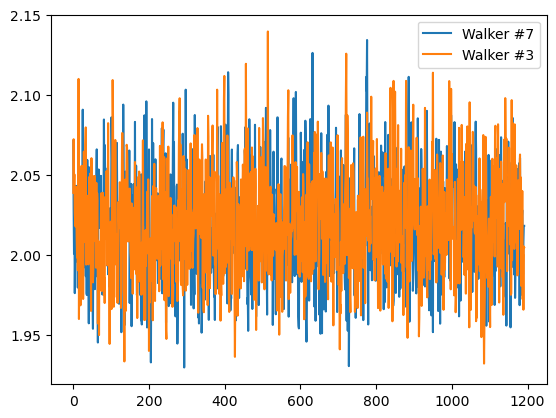

Parameter: v


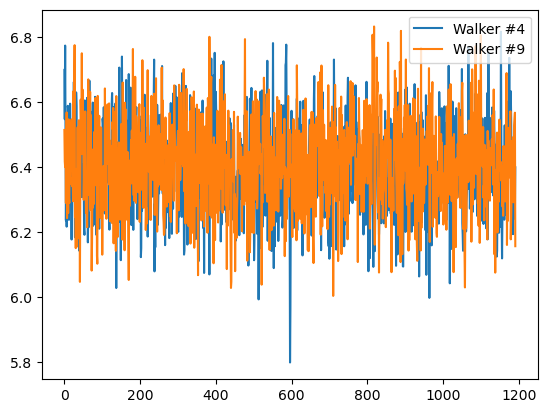

Parameter: omega2


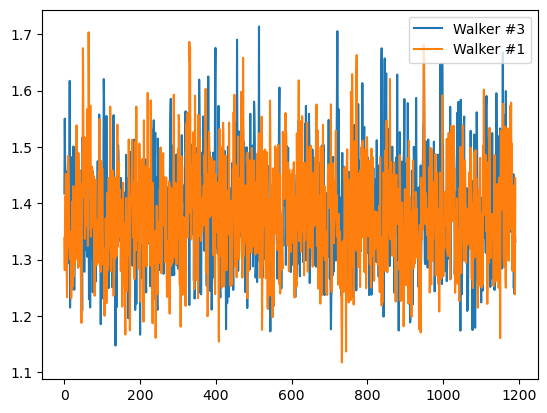

In [368]:
tau = sampler.get_autocorr_time()
max_tau=int(max(tau))
print("Tau: \n",tau, "\n Max tau: ", max_tau)

interval = np.arange(0, samples.shape[0])

param_list=["u","v","omega2"]
for i in range(0,len(param_list)):
    print("Parameter:",param_list[i])
    plotted_walkers=chainplot(chains=samples,interval=interval,parameter=i, n_plotted=2,random_pick=True,discard=discard,thin=thin,legend=True)
    for w in plotted_walkers:
        plt.plot(interval, samples[interval, w, i], label='Walker #' + str(w + 1))
        plt.legend(loc='upper right')
        plt.savefig(f"model2real_7params_{sugar}_chains_{i}.pdf",format="pdf",bbox_inches="tight")
    plt.show()
    

### log-likelihood plots at specific chain step

[   0 1191] (1192, 20, 7) [0, 12]


C:\Users\yusuf\OneDrive\Masaüstü\PoD_microbial_growth\functions.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  hazard_core = (alpha_S * k / tau) * ((p / tau) ** (k - 1)) / (1 + (p / tau) ** k)
C:\Users\yusuf\OneDrive\Masaüstü\PoD_microbial_growth\functions.py:76: RuntimeWarning: divide by zero encountered in divide
  hazard_core = (alpha_S * k / tau) * ((p / tau) ** (k - 1)) / (1 + (p / tau) ** k)
C:\Users\yusuf\OneDrive\Masaüstü\PoD_microbial_growth\functions.py:76: RuntimeWarning: invalid value encountered in divide
  hazard_core = (alpha_S * k / tau) * ((p / tau) ** (k - 1)) / (1 + (p / tau) ** k)
C:\Users\yusuf\OneDrive\Masaüstü\PoD_microbial_growth\functions.py:82: RuntimeWarning: divide by zero encountered in divide
  return 1 / (1 + (p / tau) ** k) ** alpha_S


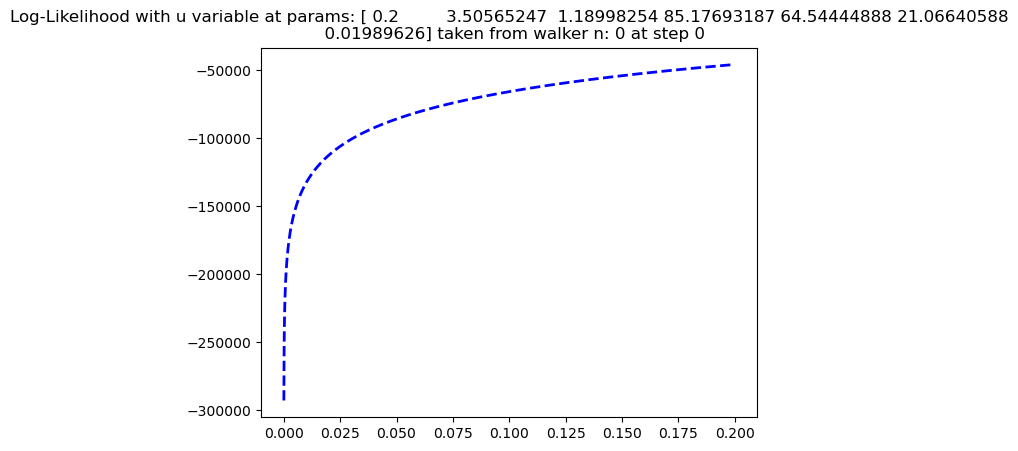

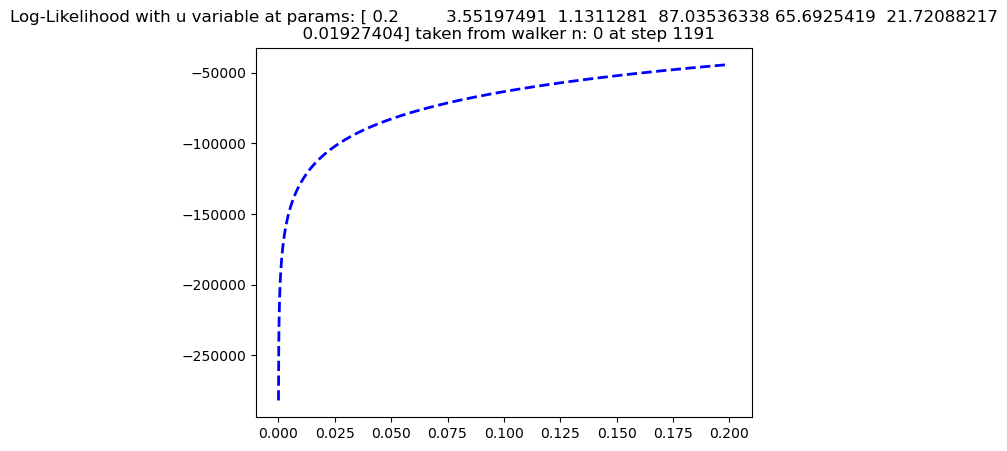

KeyboardInterrupt: 

In [81]:
n_prints=2#number of plots you want
rand_walker=[0,12]#take first and thirteenth walker


us = np.linspace(0, 0.2, 5000)
likelihoods_varying_u = np.empty(us.shape[0])
steps=np.linspace(0,samples.shape[0]-1,n_prints,dtype=np.int64)
#rand_walker=np.random.randint(0,n_walkers)
print(steps,samples.shape,rand_walker)
for rand_walker in rand_walker:
    for i in steps: 
        temp_params = samples[i,rand_walker,:]
        for k, u_i in enumerate(us):
            temp_params[0] = u_i
            likelihoods_varying_u[k] = model2.log_likelihood(temp_params, initial_mass, lineagest, timest, alphast, fst)
    
        plt.plot(us, likelihoods_varying_u, lw=2, ls='dashed', color='blue',  label='')
        plt.title(f"Log-Likelihood with u variable at params: {temp_params} taken from walker n: {rand_walker} at step {i}" )
        plt.show()

## Reload chain from file and load metadata 
***(testing purposes, this part will be put in analysis jupyter)***

In [16]:
with open(f"chain_{sugar}.txt","r") as file: comment = file.readlines()[0]
print(comment,"\n")

# Hyperparameters of Suc sugar are [n_steps n_walkers n_params ] = [30000 20 7 ]
 



In [22]:
 flat_chain=pd.DataFrame("chain_Ace.txt")


ValueError: DataFrame constructor not properly called!

In [36]:
import re

values = [int(value) for value in re.findall('[0-9]+', comment)]
print("parameters from file:",values,"\n")

print(values)

n_steps = values[0]
n_walker = values[1]
n_params = values[2]


# Load the chain from the text file
loaded_data = np.loadtxt(f"chain_{sugar}.txt")

reshaped_samples = loaded_data.reshape(n_steps,n_walker,n_params)
flat_samples=loaded_data.reshape(n_steps*n_walker,n_params)

#to chek if samples and reshaped data are exactly equal:
print(np.array_equal(s_samples,reshaped_samples))

samples=reshaped_samples
print(samples.shape,flat_samples.shape)


parameters from file: [30000, 20, 7] 

[30000, 20, 7]


NameError: name 's_samples' is not defined

## Emcee fit with less parameters (not updated)

### Emcee with 6 variable parameters (v fixed)

n_walkers = 50
n_params=6
n_steps=50000
burn_steps=int(n_steps/10)
moves=[(emcee.moves.DESnookerMove(), 0.1),(emcee.moves.DEMove(), 0.9 * 0.9),(emcee.moves.DEMove(gamma0=1.0), 0.9 * 0.1),]

#Definisco un wrapper a log_probability per il fit con 6 parametri alla volta cosicchè venga chiamata log_probability con i parametri nel posto giusto
def log_probability_vfixed(vars,v,initial_mass,lineages,t,alpha,f_i):#params will be ALL the parameters that are changeable
    params=[vars[0],v,vars[1],vars[2],vars[3],vars[4],vars[5]]#u, v, omega2,a1,b,a2,l
    return model2.log_probability(params,initial_mass,lineages,t,alpha,f_i)#this params is 7 elements long

os.environ["OMP_NUM_THREADS"] = "1"
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

#use MLE results
starting_points=np.array([u,omega2,alpha2,beta2,alpha1,scale1])
#v_true, omega2_true,alpha2_true,beta2_true,alpha1_true,scale1_true

#add gaussian noise to starting point
starting_points =starting_points + 1e-4 * np.random.randn(n_walkers, n_params)
print("starting vals: \n u omega2 alpha2 beta2 alpha1 scale1  \n",starting_points[0])
args=(v,initial_mass,lineagest,timest,alphast,fst)

#log_probability_vfixed
sampler=multiprocess_fit(starting_points,n_walkers, n_params,n_steps,burn_steps, log_probability_vfixed, args=args,moves=moves,multiprocess=True)

flat_samples2 = sampler2.get_chain(discard=100, thin=15, flat=True )
labels=["u","omega2","alpha2","beta2","alpha1","scale1"]
fig = corner.corner(flat_samples2,labels=labels,truths=[u,omega2,alpha2,beta2,alpha1,scale1],show_titles=True )
np.set_printoptions(suppress=True)#suppress scientific notation
print("Starting vals:\n",starting_points[0])
tau2 = sampler2.get_autocorr_time()
print("Autocorrelation times for \n [u,omega2,alpha2,beta2,alpha1,scale1]:\n",tau2)
plt.show()
plt.close()

samples2=sampler2.get_chain(discard=0,thin=15)
interval = np.arange(0, samples2.shape[0])
param_list=["u","omega2","alpha2_true","beta2_true","alpha1_true","scale1_true"]
for i in range(0,len(param_list)):
    print("Parameter:",param_list[i])
    model2.chainplot(sampler=sampler2,interval=interval,parameter=i,
                 n_plotted=8,random_pick=True,discard=0,thin=15,legend=True)

### Emcee with 2 variable parameters, u, omega2 (v fixed)

n_walkers = 40
n_params=2
n_steps=40000
burn_steps=int(n_steps/10)

#Definisco un wrapper a log_probability del .py per il fit con 2 parametri alla volta
def log_probability_uomega2(uomega2,v,alpha2,beta2,alpha1,scale1,initial_mass,lineages, t,alpha,f_i):#params will be ALL the parameters that are changeable
    params=[uomega2[0],v,uomega2[1],alpha2,beta2,alpha1,scale1]
    return model2.log_probability(params,initial_mass,lineages, t,alpha,f_i)#this params is 7 elements long

os.environ["OMP_NUM_THREADS"] = "1"
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

starting_points=np.array([u,omega2])
#v_true, omega2_true,alpha2,beta2,alpha1,scale1
#starting_points = np.ones((n_walkers, n_params))*starting_points
starting_points =starting_points + 1e-4 * np.random.randn(n_walkers, n_params)
print("starting vals: u omega2 \n",starting_points[0])
args=(v,alpha2, beta2, alpha1, scale1,initial_mass,lineagest,timest,alphast,fst)
sampler=multiprocess_fit(starting_points,n_walkers, n_params,n_steps,burn_steps, log_probability_uomega2, args=args)

flat_samples = sampler.get_chain(discard=0, thin=15, flat=True )
labels=["u","omega2"]
fig = corner.corner(flat_samples,labels=labels,truths=[u,omega2],show_titles=True )
np.set_printoptions(suppress=True)#suppress scientific notation
print("Starting vals:\n",starting_points[0])
tau = sampler.get_autocorr_time()
print("Autocorrelation times for \n [u,omega2]:\n",tau)
plt.show()
plt.close()

samples=sampler.get_chain(discard=0,thin=15)
interval = np.arange(0, samples.shape[0])
param_list=["u","omega2"]
for i in range(0,len(param_list)):
    print("Parameter:",param_list[i])
    model2.chainplot(sampler=sampler,interval=interval,parameter=i,
                 n_plotted=4,random_pick=True,discard=0,thin=1,legend=True)

### Emcee with 3 parameters u,v,omega2

n_walkers = 50
n_params=3
n_steps=40000
burn_steps=int(n_steps/10)

#Definisco un wrapper a log_probability del .py per il fit con 2 parametri alla volta
def log_probability_uvomega2(uvomega2,alpha2,beta2,alpha1,scale1,initial_mass,lineages, t,alpha,f_i):#params will be ALL the parameters that are changeable
    params=[uvomega2[0],uvomega2[1],uvomega2[2],alpha2,beta2,alpha1,scale1]
    return model2.log_probability(params,initial_mass,lineages, t,alpha,f_i)#this params is 7 elements long

os.environ["OMP_NUM_THREADS"] = "1"
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

starting_points=np.array([u,v,omega2])
#v_true, omega2_true,alpha2,beta2,alpha1,scale1
#starting_points = np.ones((n_walkers, n_params))*starting_points
starting_points =starting_points + 1e-4 * np.random.randn(n_walkers, n_params)
print("starting vals: u v omega2 \n",starting_points[0])
args=(alpha2, beta2, alpha1, scale1,initial_mass,lineagest,timest,alphast,fst)
sampler=multiprocess_fit(starting_points,n_walkers, n_params,n_steps,burn_steps, log_probability_uvomega2, args=args)

flat_samples = sampler.get_chain(discard=0, thin=15, flat=True )
labels=["u","v","omega2"]
fig = corner.corner(flat_samples,labels=labels,truths=[u,v,omega2],show_titles=True )
np.set_printoptions(suppress=True)#suppress scientific notation
print("Starting vals:\n",starting_points[0])
tau = sampler.get_autocorr_time()
print("Autocorrelation times for \n [u,v,omega2]:\n",tau)
plt.show()
plt.close()

samples=sampler.get_chain(discard=0,thin=15)
interval = np.arange(0, samples.shape[0])
param_list=["u","v","omega2"]
for i in range(0,len(param_list)):
    print("Parameter:",param_list[i])
    model2.chainplot(sampler=sampler,interval=interval,parameter=i,
                 n_plotted=20,random_pick=True,discard=0,thin=1,legend=True)